# Random Forest Model

In [2]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers

import jax.numpy as jnp
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
import sys
import os

# Get the absolute path to the directory containing the .py file
module_path = os.path.abspath(os.path.join('..')) # Use relative or absolute path. '..' means one level up.

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import yahoo_interface

In [11]:
df = yahoo_interface.get_all_features('NVDA', '2000-01-01', '2025-03-10')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


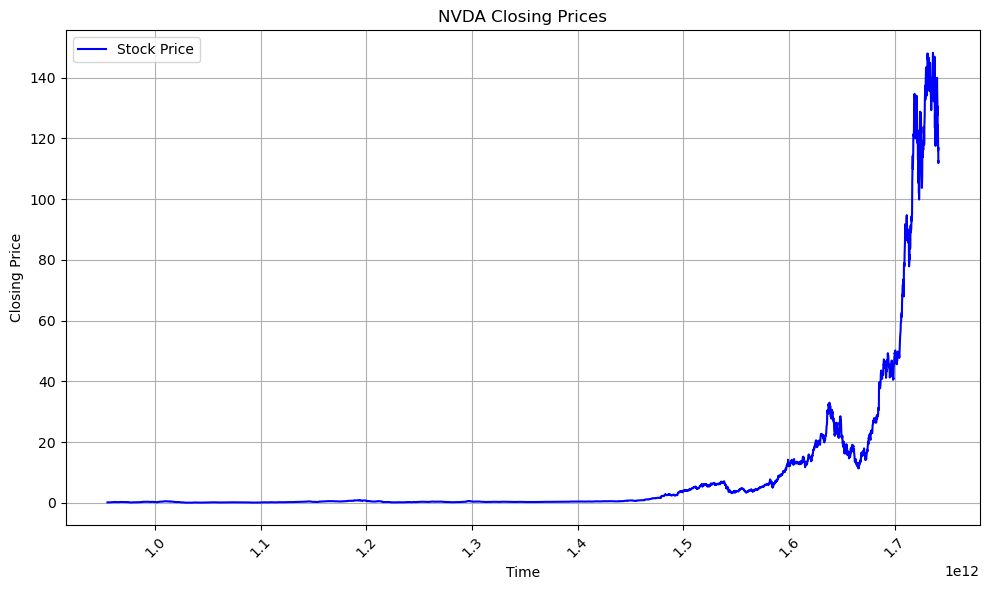

In [13]:
# Plotting the closing prices
plt.figure(figsize=(10, 6))
plt.plot(df['Timestamp'], df['Close'], color = 'blue', label = 'Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.title('NVDA Closing Prices')
plt.tight_layout()
plt.show()

In [14]:
import tensorflow as tf

In [15]:
import tensorflow_decision_forests as tfdf

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Data Processing

In [30]:
# function for creating sequences to feed into model
def create_training_sequences(data, window_size):
    """
      Returns a list of windows in data of length window_size
          and a list containing corresponding to the data value immediately proceeding a window

      :param data: a numpy array of shape (n, 1), e.g. closing_prices
      :param window_size: length of window
    """

    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i: i + window_size, 0])    # closing prices in last (seq_length)-days
        y.append(data[i + window_size, 0])       # closing price in day after the x-sequence
    return np.array(X), np.array(y)


In [17]:
chunk_size = 365
window_size = 60
X_train = np.empty((0,60), dtype = 'float64')
X_val = np.empty((0,60), dtype = 'float64')
y_train = np.empty((0), dtype = 'float64')
y_val = np.empty((0), dtype = 'float64')

for i in range(len(df)//chunk_size):
  # get chunk of dataframe
  df_chunk = df[i*chunk_size: min((i+1)*chunk_size, len(df))]

  # Put closing prices into numpy array
  closing_prices = df_chunk['Close'].values.reshape(-1, 1)

  # Normalize the data between [0,1]
  scaler = MinMaxScaler(feature_range = (0, 1))
  scaled_data = scaler.fit_transform(closing_prices)

  # Define training and validation sizes
  train_size = int(len(df_chunk) * 0.7)
  val_size = len(df_chunk) - train_size

  # Split into training and validation sets
  train, val = scaled_data[: train_size, :], scaled_data[train_size:, :]

  # Using the data sets, create sequences to feed into model
  X, y = create_training_sequences(train, window_size)
  X_train = np.concatenate((X_train, X))
  y_train = np.concatenate((y_train, y))

  X, y = create_training_sequences(val, window_size)
  X_val = np.concatenate((X_val, X))
  y_val = np.concatenate((y_val, y))

# Model Construction, Training, and Evaluation

In [32]:
def create_and_train_model(X_train, y_train, 
                           n_estimators=100, 
                           max_depth=None, 
                           min_samples_split=2, 
                           min_samples_leaf=1, 
                           random_state=42):
    """Creates, trains, and returns a RandomForestRegressor model."""
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  random_state=random_state)
    model.fit(X_train, y_train)
    return model

In [38]:
def evaluate_model(model, X_val, y_val):
    """Makes predictions and evaluates the model's performance."""
    y_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R2): {r2}")

    return y_pred

In [40]:
def visualize_predictions(y_val, y_pred):
    """Creates a scatter plot of actual vs. predicted values."""
    plt.scatter(y_val, y_pred)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values (Random Forest Regression)")
    plt.show()

In [33]:
model = create_and_train_model(X_train, y_train, n_estimators=100, max_depth=5)

In [34]:
print(model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [39]:
y_pred = evaluate_model(model, X_val, y_val)

Mean Squared Error (MSE): 0.000933205402762418
R-squared (R2): 0.990896366324961


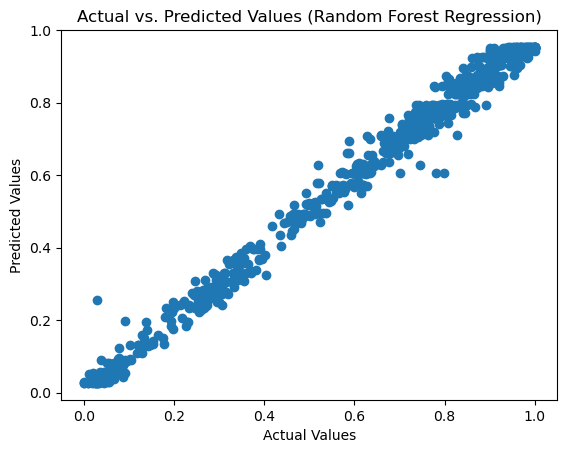

In [41]:
visualize_predictions(y_val,y_pred)

# Performance on Unsmoothed Data

In [75]:
# modified version of create_training_sequences. Only outputs X array, not y array
def create_sequences(data, window_size):
    """
      Returns a list of windows in data of length window_size
          and a list containing corresponding to the data value immediately proceeding a window

      :param data: a numpy array of shape (n, 1), e.g. closing_prices
      :param window_size: length of window
    """

    X = []
    for i in range(len(data) - window_size + 1):
        X.append(data[i: i + window_size, 0])    # closing prices in last (seq_length)-days
    return np.array(X)

In [86]:
# reading data
df = yahoo_interface.get_all_features('NVDA', '2023-01-01', '2025-01-01', smoothing = False)
closing_prices = df['Close'].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(closing_prices)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [87]:
# formatting data to be fed into model
window_size = 60
X_full = create_sequences(scaled_data, window_size)
X_full

array([[0.00648675, 0.01090359, 0.00756245, ..., 0.1188576 , 0.13091963,
        0.13182429],
       [0.01090359, 0.00756245, 0.00206989, ..., 0.13091963, 0.13182429,
        0.13104194],
       [0.00756245, 0.00206989, 0.00180909, ..., 0.13182429, 0.13104194,
        0.12929778],
       ...,
       [0.78777317, 0.80465019, 0.82747908, ..., 0.92947234, 0.92710769,
        0.90329884],
       [0.80465019, 0.82747908, 0.86963089, ..., 0.92710769, 0.90329884,
        0.90721271],
       [0.82747908, 0.86963089, 0.86767408, ..., 0.90329884, 0.90721271,
        0.8811207 ]])

In [88]:
# getting predictions
full_predict = model.predict(X_full)
full_predict

array([0.13180104, 0.13180104, 0.13157116, 0.13180104, 0.13157116,
       0.13180104, 0.14425945, 0.16601141, 0.16100397, 0.1665542 ,
       0.16933781, 0.16682802, 0.16100397, 0.15000028, 0.15226314,
       0.1615516 , 0.16100397, 0.16580032, 0.16682802, 0.16682802,
       0.16682802, 0.15000028, 0.15000028, 0.15226314, 0.16038681,
       0.15226314, 0.13180104, 0.13180104, 0.13008924, 0.14217658,
       0.14470291, 0.14071506, 0.1396643 , 0.138616  , 0.16682802,
       0.1615516 , 0.16710678, 0.16710678, 0.16601141, 0.16682802,
       0.18663937, 0.19395555, 0.19395555, 0.18361001, 0.18509816,
       0.16682802, 0.1665542 , 0.16129998, 0.15900063, 0.15253288,
       0.16100397, 0.16129998, 0.14425945, 0.14851645, 0.140948  ,
       0.13180104, 0.13129578, 0.13157116, 0.13180104, 0.13157116,
       0.13180104, 0.13510686, 0.14071506, 0.15226314, 0.14071506,
       0.14881192, 0.15226314, 0.16432491, 0.15957491, 0.16580032,
       0.16682802, 0.16682802, 0.16100397, 0.1665542 , 0.14470

In [89]:
full_predict = full_predict[:,np.newaxis]

In [91]:
full_predict = scaler.inverse_transform(full_predict)
full_predict

array([[ 42.39090455],
       [ 42.39090455],
       [ 42.36271161],
       [ 42.39090455],
       [ 42.36271161],
       [ 42.39090455],
       [ 43.91884581],
       [ 46.58658001],
       [ 45.97245039],
       [ 46.65314956],
       [ 46.99454081],
       [ 46.68673128],
       [ 45.97245039],
       [ 44.62292062],
       [ 44.90044561],
       [ 46.03961419],
       [ 45.97245039],
       [ 46.56069135],
       [ 46.68673128],
       [ 46.68673128],
       [ 46.68673128],
       [ 44.62292062],
       [ 44.62292062],
       [ 44.90044561],
       [ 45.89676059],
       [ 44.90044561],
       [ 42.39090455],
       [ 42.39090455],
       [ 42.18096349],
       [ 43.6633967 ],
       [ 43.97323364],
       [ 43.48415057],
       [ 43.35528118],
       [ 43.22671405],
       [ 46.68673128],
       [ 46.03961419],
       [ 46.72092031],
       [ 46.72092031],
       [ 46.58658001],
       [ 46.68673128],
       [ 49.11646254],
       [ 50.0137434 ],
       [ 50.0137434 ],
       [ 48

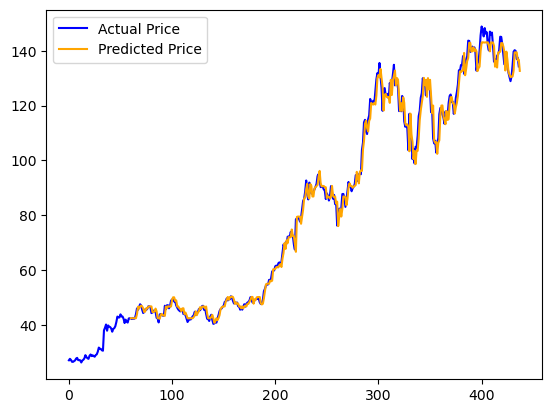

In [93]:
# Formatting data into arrays to be plotted
known_plot = np.empty((closing_prices.shape[0] + 1, 1))
known_plot[:, :] = np.nan
known_plot[:closing_prices.shape[0], :] = closing_prices

prediction_plot = np.empty((closing_prices.shape[0] + 1, 1))
prediction_plot[:, :] = np.nan
prediction_plot[window_size: closing_prices.shape[0] + 1, :] = full_predict

# Plot actual vs predictions
plt.plot(known_plot, color = 'blue', label = 'Actual Price')
plt.plot(prediction_plot, color = 'orange', label = 'Predicted Price')
plt.legend()
plt.show()

# Performance on Different Stocks

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

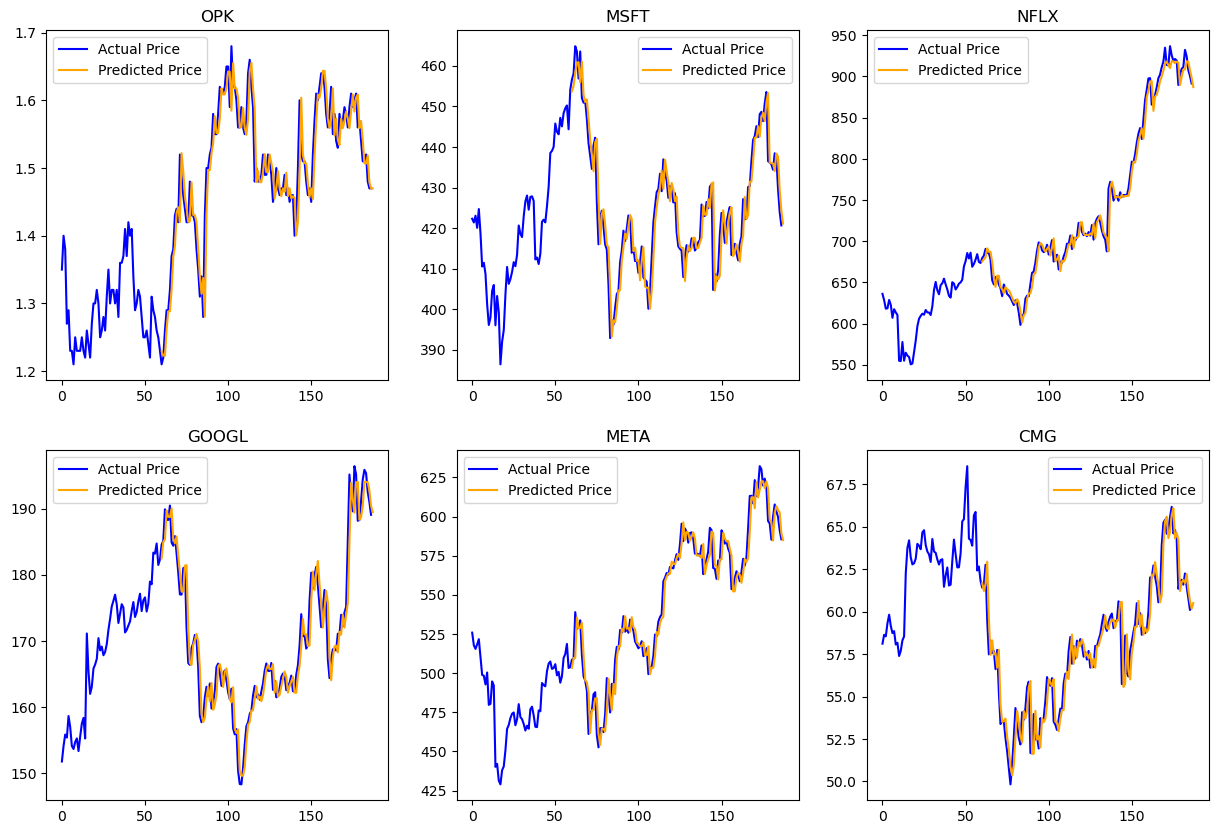

In [96]:
tickers = ['OPK', 'MSFT', 'NFLX', 'GOOGL', 'META', 'CMG']

plt.figure(figsize = (15,10))
for i in range(6):
    # reading data
    df = yahoo_interface.get_all_features(f'{tickers[i]}', '2024-01-01', '2025-01-01', smoothing = False)
    closing_prices = df['Close'].values
    closing_prices = closing_prices[:,np.newaxis]
    scaled_data = scaler.fit_transform(closing_prices)

    # formatting data to be fed into model
    window_size = 60
    X_full = create_sequences(scaled_data, window_size)

    # getting predictions
    full_predict = model.predict(X_full)
    full_predict = full_predict[:,np.newaxis]
    full_predict = scaler.inverse_transform(full_predict)

    # Plotting real vs predicted prices
    known_plot = np.empty((closing_prices.shape[0] + 1, 1))
    known_plot[:, :] = np.nan
    known_plot[:closing_prices.shape[0], :] = closing_prices

    prediction_plot = np.empty((closing_prices.shape[0] + 1, 1))
    prediction_plot[:, :] = np.nan
    prediction_plot[window_size: closing_prices.shape[0] + 1, :] = full_predict

    # set up subplots
    plt.subplot(2,3,i+1)
    plt.title(f'{tickers[i]}')
    plt.plot(known_plot, color = 'blue', label = 'Actual Price')
    plt.plot(prediction_plot, color = 'orange', label = 'Predicted Price')
    plt.legend()

plt.show()

# Applying the Model for Forecasting

In [97]:
# reading data
df_full = yahoo_interface.get_all_features('AAPL', '2005-01-01', '2006-01-01', smoothing = False)
df_predictor = df_full[:60]
closing_prices = df_predictor['Close'].values.reshape(-1, 1)

# normalizing
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(closing_prices)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [99]:
# obtaining one prediction
window_size = 60
X_one = create_sequences(scaled_data, window_size)
one_predict = model.predict(X_one)
one_predict = one_predict[:,np.newaxis]
one_predict = scaler.inverse_transform(one_predict)
one_predict[0]

array([1.10801181])

In [100]:
import math

def clipped_normal(mean=0, std = 0.33, size=1):
    values = np.random.normal(mean, std, size)
    return np.clip(values, -1, 1)

# Example usage
random_value = clipped_normal()
print(random_value)

[-0.05609976]


In [114]:
import warnings

In [115]:
warnings.filterwarnings("ignore", message="Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation.")

In [116]:
# define forecast window size
days_forward = 60

# initialize array to store future values
forecast_arr = scaled_data

# get predictions
for i in range(days_forward):
    seq = create_sequences(forecast_arr[-60:], window_size)
    one_predict = model.predict(seq)
    one_predict[0] = max(min(one_predict[0]*(1 + 0.33 * clipped_normal()), 1), -1)
    one_predict = one_predict[:,np.newaxis]
    forecast_arr = np.concatenate((forecast_arr, one_predict))

forecast_arr = scaler.inverse_transform(forecast_arr)

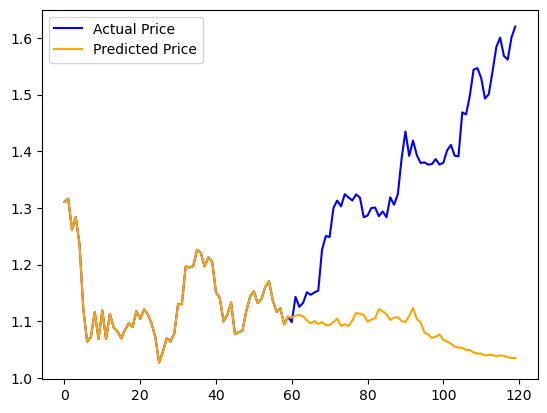

In [117]:
# Plotting real vs predicted prices
known_plot = np.empty((scaled_data.shape[0] + days_forward, 1))
known_plot[:, :] = np.nan
known_plot[:, :] = df_full['Close'][:scaled_data.shape[0] + days_forward].values.reshape(-1,1)

prediction_plot = np.empty((closing_prices.shape[0] + days_forward, 1))
prediction_plot[:, :] = np.nan
prediction_plot[: window_size + days_forward, :] = forecast_arr

# plot baseline and predictions
plt.plot(known_plot, color = 'blue', label = 'Actual Price')
plt.plot(prediction_plot, color = 'orange', label = 'Predicted Price')
plt.legend()
plt.show()